In [1]:
# Initial Import

# System packages
import os.path, sys
from pathlib import Path


# Scientific Computing packages
import numpy as np
np.random.seed(1) # set random seed for reproducibility
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial import distance_matrix, distance


# Biopython packages
import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)
from Bio import SeqIO, pairwise2

# Parallelization and computing diagnosti packages
from joblib import Parallel, delayed
import timeit

# Plotting packages
import matplotlib.pyplot as plt

import glob
import pickle
from sklearn.metrics import auc, precision_recall_curve                                                  


# # --- Import our Code ---# #
# Direct Coupling Analysis code
from direct_info import direct_info

# Import data processing and general DCA_ER tools
from data_processing import data_processing, pdb2msa
import tools
# # -----------------------# #

# Define Computational Resources
n_cpus = 10

## Define Data directories
* data_path: Where is the MSA and pdb structure data
* out_dir: Where do you want the processed MSA data to go
* pdb_dir: Where do you want the PDB-MSA reference and structure data to go

In [2]:
# Define data directories -- NEED TO DEFINE
data_path = Path('example_protein_data')
DCA_ER_dir = '.' # Set DCA_ER directory
out_dir = '%s/protein_data/di/' % DCA_ER_dir
processed_data_dir = "%s/protein_data/data_processing_output" % DCA_ER_dir
pdb_dir = '%s/protein_data/pdb_data/' % DCA_ER_dir
out_metric_dir = '%s/protein_data/metrics/' % DCA_ER_dir

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    os.makedirs(processed_data_dir)
    os.makedirs(pdb_dir)
    os.makedirs(out_metric_dir)

    

## Define PDB structure to analyse: 1ZDR

In [3]:
# Path to gzipped pdb file
pdb_path = "/pdb/pdb/zd/pdb1zdr.ent.gz"
pdb_id = "1zdr"
pfam_id = "PF00186"

## Load MSA using PDB2MSA pipeline

In [4]:
pfam_dimensions_file = "%s%s_%s_pfam_dimensions.npy" % (processed_data_dir, pdb_id, pfam_id)

import gzip, shutil
def gunzip(file_path, output_path):
    print('Unzipping %s to %s' % (file_path, output_path))
    with gzip.open(file_path,"rb") as f_in, open(output_path,"wb") as f_out:
        shutil.copyfileobj(f_in, f_out)


unzipped_pdb_filename = os.path.basename(pdb_path).replace(".gz", "")

pdb_out_path = "%s%s" % (pdb_dir, unzipped_pdb_filename)

gunzip(pdb_path, pdb_out_path)
print(pdb_out_path)
print(pdb_dir)
pdb2msa_results = pdb2msa(pdb_out_path, pdb_dir, create_new=False)
print(pdb2msa_results)

if len(pdb2msa_results) > 1:
    fasta_file = pdb2msa_results[0]
    prody_df = pdb2msa_results[1]
else:
    prody_df = pdb2msa_results[0]

rows_to_drop = []
for ir, pdb2msa_row in enumerate(prody_df.iterrows()):
    try:
        dp_result =  data_processing(data_path, prody_df.iloc[pdb2msa_row[0]], gap_seqs=0.2, gap_cols=0.2, prob_low=0.004,
                               conserved_cols=0.8, printing=False, out_dir=processed_data_dir, pdb_dir=pdb_dir, letter_format=False,
                               remove_cols=True, create_new=True)
        if dp_result is not None:
            [s0, removed_cols, s_index, tpdb, pdb_s_index] = dp_result
            break
        else:
            rows_to_drop.append(ir)
            continue
    except Exception as e:
        print('row %d got exception: ' % ir , e)
        print('moving on.. ')
        pass
print(dp_result)

pdb_id = pdb2msa_row[1]['PDB ID']
pfam_id = pdb2msa_row[1]['Pfam']
pdb_chain = pdb2msa_row[1]['Chain']
# update Prody search DF (use same filename as pdb2msa() in data_processing
prody_df = prody_df.drop(rows_to_drop)
print("\nSaving updated Prody Search DataFrame:", prody_df.head())
prody_df.to_csv('%s/%s_pdb_df.csv' % (pdb_dir, pdb_id))
# number of positions                                             
n_var = s0.shape[1]
n_seq = s0.shape[0]                                                                        
# compute effective number of sequences                                                    
dst = distance.squareform(distance.pdist(s0, 'hamming'))
theta = .2                                                                                                      # minimum necessary distance (theta = 1. - seq_identity_thresh)
seq_ints = (dst < theta).sum(axis=1).astype(float)                   
ma_inv = 1/((dst < theta).sum(axis=1).astype(float))  
meff = ma_inv.sum()

# save relevant data for categorizing contact prediction metrics
pfam_dimensions = [n_var, n_seq, meff]
np.save(pfam_dimensions_file, pfam_dimensions)




Unzipping /pdb/pdb/zd/pdb1zdr.ent.gz to ./protein_data/pdb_data/pdb1zdr.ent
./protein_data/pdb_data/pdb1zdr.ent
./protein_data/pdb_data/
[   Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  \
0           0             0               0                 0   
1           1             1               1                 1   

   Unnamed: 0.1.1.1.1  Unnamed: 0.1.1.1.1.1  Unnamed: 0.1.1.1.1.1.1  \
0                   0                     0                       0   
1                   1                     1                       1   

   Unnamed: 0.1.1.1.1.1.1.1  Unnamed: 0.1.1.1.1.1.1.1.1  \
0                         0                           0   
1                         1                           1   

   Unnamed: 0.1.1.1.1.1.1.1.1.1  ...  ali_end  ali_start  bitscore  end  \
0                             0  ...      160          1    215.11  160   
1                             1  ...      160          1    215.08  160   

    cond_evalue    ind_evalue    evidence  hmm_e

[array([[ 7, 15,  4, ...,  3, 16, 18],
       [ 9,  0,  9, ..., 17, 17, 19],
       [20, 20, 17, ..., 20, 20, 20],
       ...,
       [17, 15,  9, ..., 11, 17, 19],
       [17, 15,  0, ...,  8, 17, 19],
       [ 4, 15,  7, ...,  7,  7, 19]]), array([  0,   6,  13,  14, 143, 144,  21,  88,  26, 157,  30, 158,  95,
        96,  34,  41,  42,  43,  45,  48, 113,  53,  54,  56, 122,  60,
       126]), array([  1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  12,  15,  16,
        17,  18,  19,  20,  22,  23,  24,  25,  27,  28,  29,  31,  32,
        33,  35,  36,  37,  38,  39,  40,  44,  46,  47,  49,  50,  51,
        52,  55,  57,  58,  59,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  89,  90,  91,  92,  93,  94,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 123, 124, 125,
       127, 128, 129, 1

## Generate True Positive and False Positive rates using PDB structure and predicted DI

In [5]:
ct, ct_full = tools.contact_map(pdb2msa_row[1], pdb_out_path, removed_cols, s_index, pdb_out_dir=pdb_dir, printing=True)
ct_file = "%s%s_%s_ct.npy" % (pdb_dir, pdb_id, pfam_id)
np.save(ct_file, ct)
ct_mat = ct

# find optimal threshold of distance
ct_thres = np.linspace(4.,10.,18,endpoint=True)
n = ct_thres.shape[0]
ld_threshold = 5




#-----------------------#
Generating Contact Map
#----------------------------#

0 160
new poly seq list:  METILESERHISILEVALALAMETASPGLUASNARGVALILEGLYLYSASPASNARGLEUPROTRPHISLEUPROALAASPLEUALATYRPHELYSARGVALTHRMETGLYHISALAILEVALMETGLYARGLYSTHRPHEGLUALAILEGLYARGPROLEUPROGLYARGASPASNVALVALVALTHRGLYASNARGSERPHEARGPROGLUGLYCYSLEUVALLEUHISSERLEUGLUGLUVALLYSGLNTRPILEALASERARGALAASPGLUVALPHEILEILEGLYGLYALAGLULEUPHEARGALATHRMETPROILEVALASPARGLEUTYRVALTHRLYSILEPHEALASERPHEPROGLYASPTHRPHETYRPROPROILESERASPASPGLUTRPGLUILEVALSERTYRTHRPROGLYGLYLYSASPGLULYSASNPROTYRGLUHISALAPHEILEILETYRGLUARG

Chain  <Chain id=B> :
 MISHIVAMDENRVIGKDNRLPWHLPADLAYFKRVTMGHAIVMGRKTFEAIGRPLPGRDNVVVTGNRSFRPEGCLVLHSLEEVKQWIASRADEVFIIGGAELFRATMPIVDRLYVTKIFASFPGDTFYPPISDDEWEIVSYTPGGKDEKNPYEHAFIIYER

 MISHIVAMDENRVIGKDNRLPWHLPADLAYFKRVTMGHAIVMGRKTFEAIGRPLPGRDNVVVTGNRSFRPEGCLVLHSLEEVKQWIASRADEVFIIGGAELFRATMPIVDRLYVTKIFASFPGDTFYPPISDDEWEIVSYTPGGKDEKNPYEHAFIIYER 

poly_seq_range (160)
pp seq coordinates (160)
Aligned poly_s

### Load DI for all methods

In [6]:
ER_di = np.load("%s/%s_%s_ER_di.npy" % (out_dir, pdb_id, pfam_id))


PMF_di_data = np.load("%s/%s_PMF_di.npy" % (out_dir, pfam_id),allow_pickle=True)
PLM_di_data = np.load("%s/%s_PLM_di.npy" % (out_dir, pfam_id),allow_pickle=True)

### Calculate ER TP/FP

In [7]:

auc_ER = np.zeros(n)
# Get AUC for different contact thresholds to find best possible performance of method
for i in range(n):
    try:
        fpr, tpr, thresholds, auc, ct_pos_flat = tools.generate_roc_curve(ct_mat, ER_di, ct_thres[i] ,s_index, ld_thresh=ld_threshold, get_uniform=False)
        auc_ER[i] = auc
    except:
        auc_ER[i] = 0

# Get ER method's best contact prediction
i0_ER = np.argmax(auc_ER)
print('ER auc max:',ct_thres[i0_ER],auc_ER[i0_ER])
fpr0_ER, tpr0_ER, thresholds_ER, auc_ER, ER_ct_pos_flat = tools.generate_roc_curve(ct_mat, ER_di, ct_thres[i0_ER], s_index, ld_thresh=ld_threshold, get_uniform=False)

fp_file = "%s%s_%s_ER_fp.npy" % (out_metric_dir, pdb_id, pfam_id)
tp_file = "%s%s_%s_ER_tp.npy" % (out_metric_dir, pdb_id, pfam_id)
np.save(fp_file, fpr0_ER)
np.save(tp_file, tpr0_ER)

ct_pos_file = "%s%s_%s_ER_ct_flat.npy" % (processed_data_dir, pdb_id, pfam_id)
np.save(ct_pos_file, ER_ct_pos_flat)



ct thresh 8.941176 gives auc = 0.924446
ct thresh 9.294118 gives auc = 0.924446
ct thresh 9.647059 gives auc = 0.970705
ct thresh 10.000000 gives auc = 0.970705
ER auc max: 9.647058823529413 0.9707053469852105
ct thresh 9.647059 gives auc = 0.970705


### Calculate PYDCA MF TP/FP

In [8]:
# PMF ROC
# translate PMF di tuple to contact matrix
PMF_di = np.zeros(ER_di.shape)
PMF_di_dict = {}
for score_set in PMF_di_data:
    PMF_di_dict[(score_set[0][0], score_set[0][1])] = score_set[1]
for i, index_i in enumerate(s_index):
    for j, index_j in enumerate(s_index):
        if i==j:
            PMF_di[i,j] = 1.
            continue
        try:
            PMF_di[i,j] = PMF_di_dict[(index_i, index_j)]
            PMF_di[j,i] = PMF_di_dict[(index_i, index_j)] # symetric
        except(KeyError):
            continue

auc_PMF = np.zeros(n)
# Get AUC for different contact thresholds to find best possible performance of method
for i in range(n):
    try:
        fpr, tpr, thresholds, auc, ct_pos_flat = tools.generate_roc_curve(ct_mat, PMF_di, ct_thres[i] ,s_index, ld_thresh=ld_threshold, get_uniform=False)
        auc_PMF[i] = auc
    except:
        auc_PMF[i] = 0

# Get PMF method's best contact prediction
i0_PMF = np.argmax(auc_PMF)
print('PMF auc max:',ct_thres[i0_PMF],auc_PMF[i0_PMF])
fpr0_PMF, tpr0_PMF, thresholds_PMF, auc_PMF, PMF_ct_pos_flat = tools.generate_roc_curve(ct_mat, PMF_di, ct_thres[i0_PMF], s_index, ld_thresh=ld_threshold, get_uniform=False)

fp_file = "%s%s_%s_PMF_fp.npy" % (out_metric_dir, pdb_id, pfam_id)
tp_file = "%s%s_%s_PMF_tp.npy" % (out_metric_dir, pdb_id, pfam_id)
np.save(fp_file, fpr0_PMF)
np.save(tp_file, tpr0_PMF)

ct_pos_file = "%s%s_%s_PMF_ct_flat.npy" % (processed_data_dir, pdb_id, pfam_id)
np.save(ct_pos_file, PMF_ct_pos_flat)

ct thresh 8.941176 gives auc = 0.960273
ct thresh 9.294118 gives auc = 0.960273
ct thresh 9.647059 gives auc = 0.984398
ct thresh 10.000000 gives auc = 0.984398
PMF auc max: 9.647058823529413 0.984397854705022
ct thresh 9.647059 gives auc = 0.984398


In [9]:
# PLM ROC
# translate PLM di tuple to contact matrix
PLM_di = np.zeros(ER_di.shape)
PLM_di_dict = {}
for score_set in PLM_di_data:
    PLM_di_dict[(score_set[0][0], score_set[0][1])] = score_set[1]
for i, index_i in enumerate(s_index):
    for j, index_j in enumerate(s_index):
        if i==j:
            PLM_di[i,j] = 1.
            continue
        try:
            PLM_di[i,j] = PLM_di_dict[(index_i, index_j)]
            PLM_di[j,i] = PLM_di_dict[(index_i, index_j)] # symetric
        except(KeyError):
            continue

auc_PLM = np.zeros(n)
# Get AUC for different contact thresholds to find best possible performance of method
for i in range(n):
    try:
        fpr, tpr, thresholds, auc, ct_pos_flat = tools.generate_roc_curve(ct_mat, PLM_di, ct_thres[i] ,s_index, ld_thresh=ld_threshold, get_uniform=False)
        auc_PLM[i] = auc
    except:
        auc_PLM[i] = 0

# Get PMF method's best contact prediction
i0_PLM = np.argmax(auc_PLM)
print('PPLM auc max:',ct_thres[i0_PLM],auc_PLM[i0_PLM])
fpr0_PLM, tpr0_PLM, thresholds_PLM, auc_PLM, PLM_ct_pos_flat = tools.generate_roc_curve(ct_mat, PLM_di, ct_thres[i0_PLM], s_index, ld_thresh=ld_threshold, get_uniform=False)

fp_file = "%s%s_%s_PLM_fp.npy" % (out_metric_dir, pdb_id, pfam_id)
tp_file = "%s%s_%s_PLM_tp.npy" % (out_metric_dir, pdb_id, pfam_id)
np.save(fp_file, fpr0_PLM)
np.save(tp_file, tpr0_PLM)

ct_pos_file = "%s%s_%s_PLM_ct_flat.npy" % (processed_data_dir, pdb_id, pfam_id)
np.save(ct_pos_file, PLM_ct_pos_flat)

ct thresh 8.941176 gives auc = 0.809895
ct thresh 9.294118 gives auc = 0.809895
ct thresh 9.647059 gives auc = 0.934625
ct thresh 10.000000 gives auc = 0.934625
PPLM auc max: 9.647058823529413 0.9346253859905737
ct thresh 9.647059 gives auc = 0.934625


## Plot and Compare Different Methods

In [10]:
import single_protein_plot_pydca as protein_plotting
from pydca.contact_visualizer import contact_visualizer


In [11]:
# Conform DI scores to PYDCA format
from tools import scores_matrix2dict
ER_scores = scores_matrix2dict(ER_di, s_index)
er_scores_ordered = {}
for [pair, score] in ER_scores:
    er_scores_ordered[pair] = score
ER_scores_pydca = er_scores_ordered
ER_scores_pydca = sorted(ER_scores_pydca.items(), key =lambda k : k[1], reverse=True)


plm_scores_ordered = {}
for [pair, score] in PLM_di_data:
    plm_scores_ordered[pair] = score
plmdca_scores_pydca = plm_scores_ordered
plmdca_scores_pydca = sorted(plmdca_scores_pydca.items(), key =lambda k : k[1], reverse=True)


mf_scores_ordered = {}
for [pair, score] in PMF_di_data:
    mf_scores_ordered[pair] = score
mfdca_scores_pydca = mf_scores_ordered
mfdca_scores_pydca = sorted(mfdca_scores_pydca.items(), key =lambda k : k[1], reverse=True)




# Define contact_visualizer instances for plotting the results on the different methods
ref_outfile = Path(processed_data_dir, '%s_ref.fa' % pfam_id)

ld = 5
contact_dist = 5.
plmdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb_chain, pdb_id,
    refseq_file = str(ref_outfile),
    sorted_dca_scores = plmdca_scores_pydca,
    linear_dist = ld,
    contact_dist = contact_dist
)

mfdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb_chain, pdb_id,
    refseq_file = str(ref_outfile),
    sorted_dca_scores = mfdca_scores_pydca,
    linear_dist = ld,
    contact_dist = contact_dist
)

er_visualizer = contact_visualizer.DCAVisualizer('protein', pdb_chain, pdb_id,
        refseq_file = str(ref_outfile),
        sorted_dca_scores = ER_scores_pydca,
        linear_dist = ld,
        contact_dist = contact_dist,
)




	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.

	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.

	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


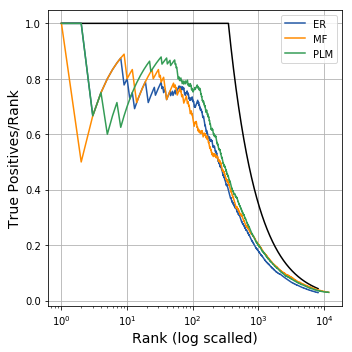

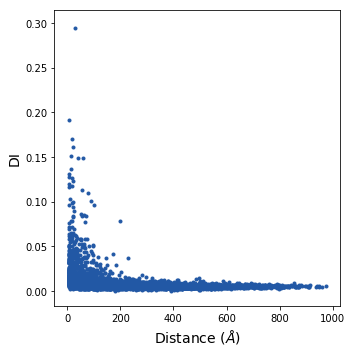

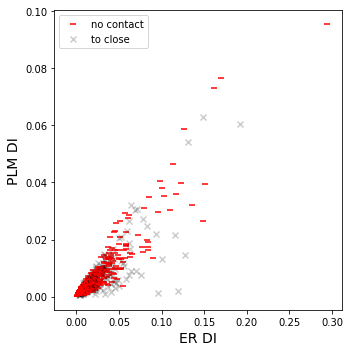

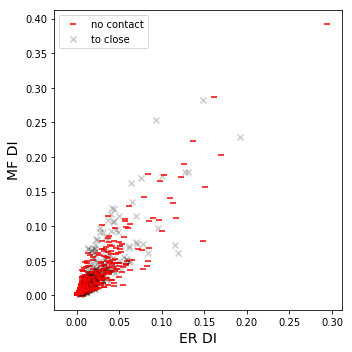

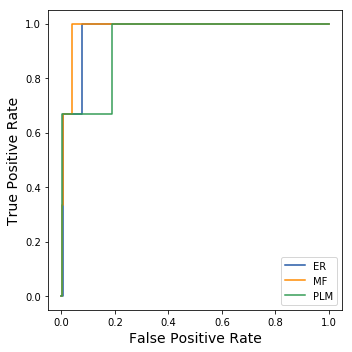

In [22]:
# define plot colors 
colors_hex = {"red": "#e41a1c", "blue": "#2258A5", "green": "#349C55", "purple": "#984ea3", "orange": "#FF8B00",
                      "yellow": "#ffff33", "grey": "#BBBBBB"}
colors_key = ["blue", "orange", "green"]



# get ER-ordered list of DI pairs along with distance-threshold booleans in same order
mask = np.triu(np.ones(ER_di.shape[0], dtype=bool), k=1)
# argsort sorts from low to high. [::-1] reverses 
order = ER_di[mask].argsort()[::-1]
ld_thresh = 4.
linear_distance = np.zeros((len(s_index),len(s_index)))
for i, ii in enumerate(s_index):
    for j, jj in enumerate(s_index):
        linear_distance[i,j] = abs(ii - jj)
ld = linear_distance >= ld_thresh


ld_flat = ld[mask][order]
ER_di_flat = ER_di[mask][order]
PLM_di_flat = PLM_di[mask][order]
PMF_di_flat = PMF_di[mask][order]
ct_flat = ct[mask][order]
dist_flat = ct[mask][order]


colors = ['b', 'r', 'g']
protein_plotting.pydca_tp_plot( [er_visualizer, mfdca_visualizer, plmdca_visualizer], methods = [ 'ER', 'MF','PLM'], pdb_id=pdb_id, pfam_id=pfam_id ,ld=5, contact_dist=5.)


labels = ['ER']
flat_dis =  [ER_di_flat]

plt.figure(figsize=(5,5))
ax = plt.subplot2grid((1,1),(0,0))
ax = protein_plotting.plot_di_vs_ct(ax, ct_flat, dist_flat, flat_dis, ld_flat, labels)
plt.tight_layout()
# ax.legend()
plt.savefig('%s_%s_%s_di_dist.pdf' % (pdb_id, pfam_id, 'ER') )


# ---

flat_dis =  [ER_di_flat, PLM_di_flat]
labels = ['ER', 'PLM']
plt.figure(figsize=(5,5))
ax = plt.subplot2grid((1,1),(0,0))
ax = protein_plotting.plot_di_compare_methods(ax, ct_flat, flat_dis[0], flat_dis[1], ld_flat, labels)
ax.legend()

plt.tight_layout()
plt.savefig('%s_%s_di_contact_%sv%s.pdf' % (pdb_id, pfam_id, labels[0],labels[1]) )


flat_dis =  [ER_di_flat, PMF_di_flat]
labels = ['ER', 'MF']
plt.figure(figsize=(5,5))
ax2 = plt.subplot2grid((1,1),(0,0))
ax2 = protein_plotting.plot_di_compare_methods(ax2, ct_flat, flat_dis[0], flat_dis[1], ld_flat, labels)
ax2.legend()
plt.tight_layout()
plt.savefig('%s_%s_di_contact_%sv%s.pdf' % (pdb_id, pfam_id, labels[0],labels[1]) )

plt.figure(figsize=(5,5))
ax = plt.subplot2grid((1,1),(0,0))
ax.plot(fpr0_ER, tpr0_ER, label='ER', color=protein_plotting.colors_hex[colors_key[0]])
ax.plot(fpr0_PMF, tpr0_PMF, label='MF', color=protein_plotting.colors_hex[colors_key[1]])
ax.plot(fpr0_PLM, tpr0_PLM, label='PLM', color=protein_plotting.colors_hex[colors_key[2]])
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.legend()
plt.tight_layout()
